# 프로젝트: 네이버 영화 리뷰 데이터를 활용한 감성 분석

## 패키지 임포트 및 데이터 살펴보기

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
from konlpy.tag import Mecab # 이것을 활용해도 됨
from collections import Counter


# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/data/ratings_train.txt')
test_data = pd.read_table('~/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [2]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [3]:
len(train_data)

150000

In [4]:
train_data.describe()

,id,label
count,1.500000e+05,150000.000000
mean,6.743533e+06,0.498847
std,2.919051e+06,0.500000
min,3.300000e+01,0.000000
25%,4.766881e+06,0.000000
50%,7.526840e+06,0.000000
75%,9.249435e+06,1.000000
max,1.027815e+07,1.000000


## 데이터 전처리

In [5]:
# 중복된 데이터를 삭제한다.
train_data.drop_duplicates(inplace = True,subset = ["document"], keep = "first")
test_data.drop_duplicates(inplace = True, subset = ["document"], keep = "first")
print('총 샘플의 수(train) :',len(train_data))
print('총 샘플의 수(test) :',len(test_data))

총 샘플의 수(train) : 146183
총 샘플의 수(test) : 49158


In [6]:
# 결측치 데이터를 삭제한다.
train_data.dropna(how = "any", inplace = True)
test_data.dropna(how = "any", inplace = True)
print('총 샘플의 수(train) :',len(train_data))
print('총 샘플의 수(test) :',len(test_data))

총 샘플의 수(train) : 146182
총 샘플의 수(test) : 49157


In [7]:
# 하나의 문자로 되어 있는 경우 이를 공백으로 대체한다.
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)
train_data[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [8]:
# 특수 문자를 제거한다.
train_data['document'] = train_data['document'].str.replace('^ +', "", regex=True) # white space 데이터를 empty value로 변경
# 공백으로만 되어 있는 부분을 이제 nan으로 대체한다.
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id            0
document    789
label         0
dtype: int64


In [9]:
train_data.loc[train_data.document.isnull()][:5]

,id,document,label
404,4221289,NaN,0
412,9509970,NaN,1
470,10147571,NaN,1
584,7117896,NaN,0
593,6478189,NaN,0


In [10]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

145393


In [11]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True) # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "", regex=True) # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48852


## 불용어 처리 및 tokenizaion

In [12]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [13]:
X_train = []
for sentence in tqdm(train_data['document']):
    if isinstance(sentence, str):  # sentence가 문자열일 경우에만 실행
        tokenized_sentence = Mecab().morphs(sentence)  # 형태소 분석
        stopwords_removed_sentence = [word for word in tokenized_sentence if word not in stopwords]  # 불용어 제거
        X_train.append(stopwords_removed_sentence)
    else:
        print(f"Not a valid sentence: {sentence}")

100%|██████████| 145393/145393 [03:14<00:00, 747.51it/s]


In [14]:
print(X_train[:3])


[['아', '더', '빙', '진짜', '짜증', '나', '네요', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍', '지', '않', '구나'], ['너무', '재', '밓었다그래서보는것을추천한다']]


In [15]:
X_test = []
for sentence in tqdm(test_data['document']):
    if isinstance(sentence, str):
        tokenized_sentence = Mecab().morphs(sentence) # 토큰화
        stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
        X_test.append(stopwords_removed_sentence)
    else:
        print(f"Not a valid sentence: {sentence}")

100%|██████████| 48852/48852 [01:05<00:00, 745.56it/s]


In [16]:
tokenizer = Tokenizer() # text를 indexing함
tokenizer.fit_on_texts(X_train) # 빈도수를 바탕으로 indexing을 함
tokenizer.word_index = {k: (v+3) for k, v in tokenizer.word_index.items()}  # 기존 단어 인덱스에 +3을 추가
tokenizer.word_index['<PAD>'] = 0  # 0번 인덱스: 패딩
tokenizer.word_index['<START>'] = 1  # 1번 인덱스: 시작 토큰
tokenizer.word_index['<OOV>'] = 2  # 2번 인덱스: OOV (사전에 없는 단어)

In [17]:
# print(tokenizer.word_index)


## 단어의 빈도수 확인

In [19]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 49949
등장 빈도가 2번 이하인 희귀 단어의 수: 28320
단어 집합에서 희귀 단어의 비율: 56.69783178842419
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.7606779759006361


In [20]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 21630


### 빈도수가 낮은 토큰들을 처리하는 방법
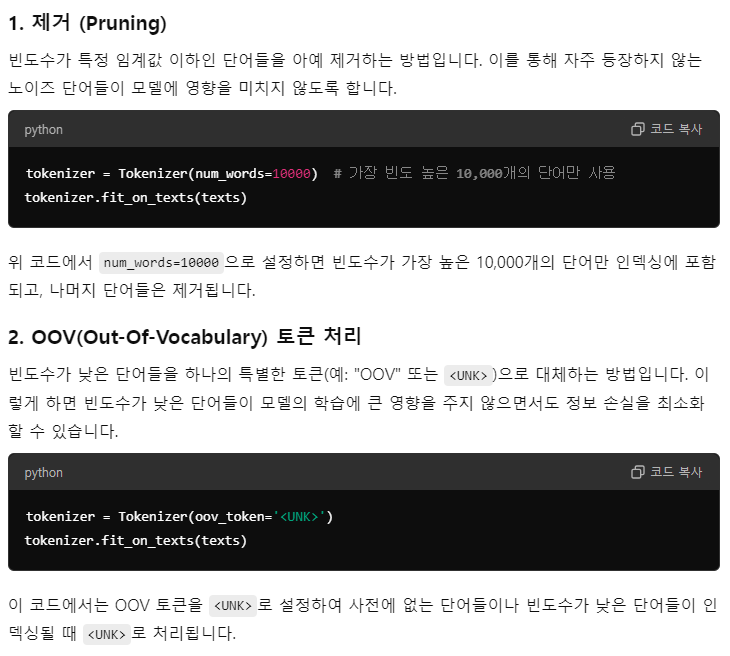
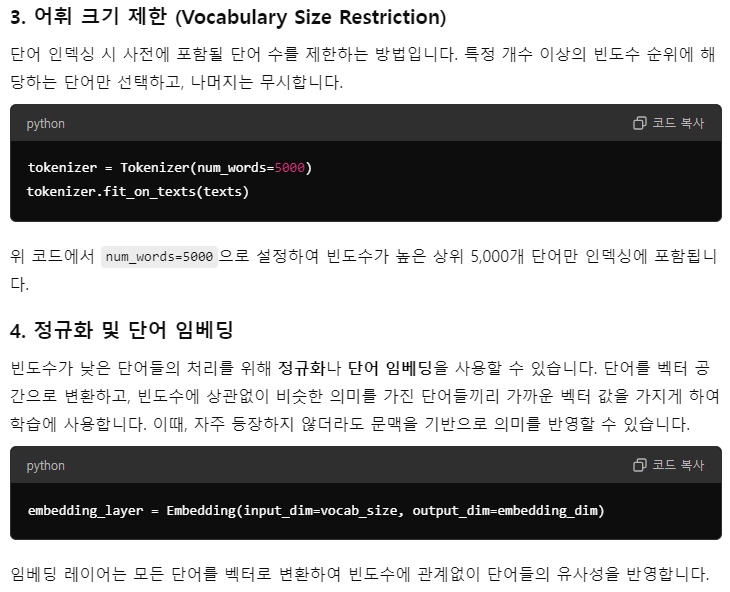

## 빈도수가 낮은 단어 처리(제거 또는 OOV)

In [21]:
# 제거
# tokenizer = Tokenizer(vocab_size)
# 특정 갯수만 인덱싱
tokenizer = Tokenizer(num_words = 10000, oov_token = "<OOV")

tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [22]:
print(X_train[:3])


[[24, 64, 892, 30, 211, 12, 25, 696], [974, 478, 488, 633, 1, 107, 1551, 45, 861, 946, 8, 35, 361], [16, 189]]


In [23]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [24]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [25]:
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

145190
145190


/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


## 리뷰 길이의 분포

리뷰의 최대 길이 : 83
리뷰의 평균 길이 : 13.576155382602108


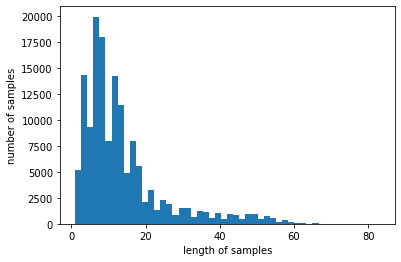

In [26]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
# map(len, X_train) X_train의 각 데이터에 len() 함수를 적용한 결과이다!
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [27]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [28]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 90.908464770301


In [29]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

y_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)
print(x_train.shape)

## 학습 과정1: LSTM

In [30]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4) # validation loss가 4epoch 동안 감소하지 않으면 학습을 중단한다.
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True) # 학습 중에서 validation accuracy가 가장 높은 모델을 저장한다.

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
1815/1815 [==============================] - 40s 6ms/step - loss: 0.3885 - acc: 0.8235 - val_loss: 0.3502 - val_acc: 0.8452

Epoch 00001: val_acc improved from -inf to 0.84524, saving model to best_model.h5
Epoch 2/15
1815/1815 [==============================] - 10s 5ms/step - loss: 0.3224 - acc: 0.8611 - val_loss: 0.3303 - val_acc: 0.8576

Epoch 00002: val_acc improved from 0.84524 to 0.85763, saving model to best_model.h5
Epoch 3/15
1815/1815 [==============================] - 9s 5ms/step - loss: 0.2941 - acc: 0.8767 - val_loss: 0.3225 - val_acc: 0.8616

Epoch 00003: val_acc improved from 0.85763 to 0.86160, saving model to best_model.h5
Epoch 4/15
1815/1815 [==============================] - 9s 5ms/step - loss: 0.2726 - acc: 0.8882 - val_loss: 0.3187 - val_acc: 0.8661

Epoch 00004: val_acc improved from 0.86160 to 0.86614, saving model to best_model.h5
Epoch 5/15
1815/1815 [==============================] - 9s 5ms/step - loss: 0.2551 - acc: 0.8964 - val_loss: 0.3229 - val

## 테스트 과정1

In [31]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1527/1527 [==============================] - 4s 2ms/step - loss: 0.3240 - acc: 0.8633

 테스트 정확도: 0.8633


In [32]:
with open('tokenizer.pickle', 'wb') as handle:
     pickle.dump(tokenizer, handle)

with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [39]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = Mecab().morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [40]:
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ')


97.72% 확률로 긍정 리뷰입니다.



In [41]:
sentiment_predict('이딴게 영화냐 ㅉㅉ')


99.83% 확률로 부정 리뷰입니다.



In [42]:
sentiment_predict('와 개쩐다 정말 세계관 최강자들의 영화다')


87.14% 확률로 긍정 리뷰입니다.



## 학습과정2: CNN

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

## 학습과정3: GlobalMaxPooling Layer만 있는 경우

In [ ]:
vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

## 학습과정3: Embedding Layer의 변경

In [ ]:
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/data/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [ ]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

In [ ]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

In [ ]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

## 회고
-아직 코드를 미완성해서 이번주 주말 안에 완성할 예정입니다!